# Praca domowa 8

In [1]:
import numpy as np
import pandas as pd 

train = pd.read_csv("lowbwt.csv")

Opis zbioru danych:

https://www.openml.org/d/203

Dane pochodzą z badania przeprowadzonego w celu zidentyfikowania czynników związanych z urodzeniem dziecka o niskiej wadze urodzeniowej (mniej niż 2500 gram). Dane zebrano od 189 kobiet, z których 59 miało dzieci o niskiej wadze urodzeniowej.

- LOW Low Birth Weight (0 = Birth Weight > 2500g,  1 = Birth Weight < 2500g)

- AGE Age of the Mother in Years 

- LWT Weight in Pounds at the Last Menstrual Period 

- RACE Race (1 = White, 2 = Black, 3 = Other) 

- SMOKE Smoking Status During Pregnancy (1 = Yes, 0 = No) 

- PTL History of Premature Labor (0 = None, 1 = One, etc.) 

- HT History of Hypertension (1 = Yes, 0 = No) 

- UI Presence of Uterine Irritability (1 = Yes, 0 = No) 

- FTV Number of Physician Visits During the First Trimester  (0 = None, 1 = One, 2 = Two, etc.)

- BWT Birth Weight in Grams (class)

In [2]:
train.head(5)

,LOW,AGE,LWT,RACE,SMOKE,PTL,HT,UI,FTV,class
0,0,19,182,2,0,0,0,1,0,2523
1,0,33,155,3,0,0,0,0,3,2551
2,0,20,105,1,1,0,0,0,1,2557
3,0,21,108,1,1,0,0,1,2,2594
4,0,18,107,1,1,0,0,1,0,2600


In [3]:
train.shape

(189, 10)

In [169]:
from sklearn.model_selection import train_test_split

X = train.loc[:, train.columns != 'class']
y = train.loc[:,'class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [202]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

random_forest = RandomForestRegressor(max_depth=3, random_state=5,n_estimators=150,warm_start=True)
random_forest.fit(X_train, y_train)
y_pred = random_forest.predict(X_test)

mse_rf = mean_squared_error(y_pred,y_test)

print("RandomForestRegressor MSE score: " + str(mse_rf))

RandomForestRegressor MSE score: 174846.04491389784


In [203]:
# wspolczynnik R^2
random_forest.score(X_test,y_test)

0.6401975833777491

In [205]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

cat = CatBoostRegressor(iterations=500,depth=1,loss_function='RMSE',verbose=False)
cat.fit(X_train, y_train)
cat_pred = cat.predict(X_test)

mse_cat = mean_squared_error(cat_pred,y_test)

print("CatBoostRegressor MSE score: " + str(mse_cat))

CatBoostRegressor MSE score: 195569.88992034175


### Funkcje rysujące wykresy

In [9]:
import matplotlib.pyplot as plt
import ruptures as rpt

def ceteris_paribus_plot(data,model,num_feature,n):
    X_temp_1 = data.copy().head(n)
    
    f_min, f_max = data[num_feature].min(), data[num_feature].max()
    start, stop = (f_min, f_max)
    num_feature_values = np.linspace(start, stop, n, dtype=int)
    
    X_temp_1[num_feature] = num_feature_values
    
    y_pred = model.predict(X_temp_1)
    
    plt.plot(num_feature_values, y_pred)
    plt.xlabel(num_feature)
    plt.ylabel("Prawdopodobieństwo małżeństwa")
    pred_values = pd.DataFrame({'Feature_value':num_feature_values,'Prediction':y_pred})
    
    return pred_values.drop_duplicates().reset_index(drop=True)

In [48]:
def Mplot(m,penalty,model,num_feature, data):
    
    n=100
    sample = data.sample(n).reset_index(drop=True)
    results = pd.DataFrame(columns=['Feature_value', 'Prediction'])

    for i in range(n):
        X_temp = data.copy()
        for column_name in X_temp.columns:
            X_temp.loc[:,column_name] = int(sample.iloc[i][column_name])
    
        tmp = ceteris_paribus_plot(X_temp,model,num_feature,100)
        results = results.append(tmp, ignore_index=True)
    
    feature_values = sorted(list(data[num_feature].drop_duplicates()))
    mean_values = []

    for i in feature_values:
        tmp = np.mean(results[results.Feature_value.isin([i-m,i,i+m])])['Prediction']
        mean_values.append(tmp)
        
    plt.plot(feature_values, mean_values,'blue',linewidth=3)
    plt.xlabel(num_feature)
    plt.ylabel("Weight value")
    
    algo = rpt.Pelt(model="l1").fit(np.asarray(mean_values).reshape(len(mean_values), -1))
    my_bkps = algo.predict(pen=penalty)

    breakpoints = []
    for i in range(len(my_bkps)-1):
        plt.axvline(feature_values[my_bkps[i]-1], color = 'red', linestyle = ':', markersize = 10, zorder = 10)
        breakpoints.append(feature_values[my_bkps[i]-1])
    plt.show()
    
    return breakpoints

### Wykresy M-plot z zaznaczonymi przełomowymi punktami

/home/kasia/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: Invalid value encountered in median for 1 results
  r = func(a, **kwargs)


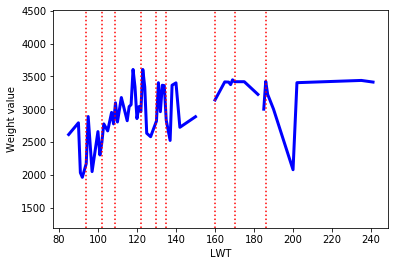

In [49]:
LWT_breakpoints = Mplot(5,0.5, random_forest, "LWT", X_train)

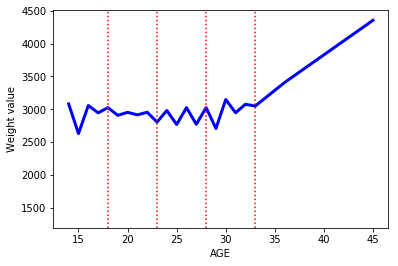

In [60]:
AGE_breakpoints = Mplot(2,0.4, random_forest, "AGE", X_train)

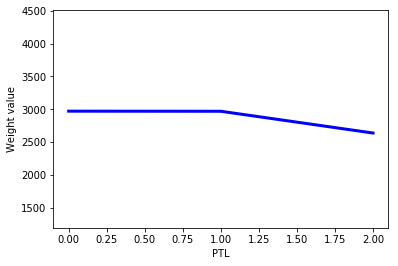

In [55]:
PTL_breakpoints = Mplot(1,0.01,random_forest, "PTL", X_train)

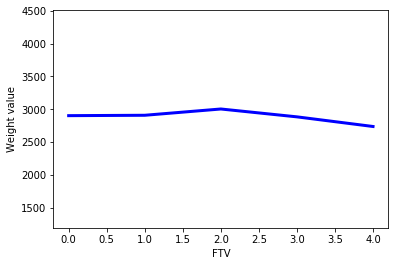

In [57]:
FTV_breakpoints = Mplot(1,0.01,random_forest, "FTV", X_train)

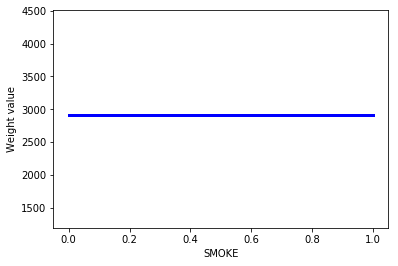

In [54]:
SMOKE_breakpoints = Mplot(1,0.01,random_forest, "SMOKE", X_train)

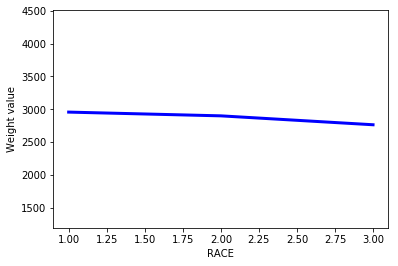

In [56]:
RACE_breakpoints = Mplot(1,0.01,random_forest,"RACE",X_train)

Ze względu na małą różnorodność pomiędzy wartościami zmiennych PTL, FTV, SMOKE, RACE, nie wykryto w nich żadnych punktów przełomowych. 

Z tego powodu przekształcono tylko dwie zmienne, które zostaną dodane do modelu: AGE oraz LWT.

In [61]:
AGE_breakpoints

[18, 23, 28, 33]

In [59]:
LWT_breakpoints

[94, 102, 109, 122, 130, 135, 160, 170, 186]

In [154]:
def func(row,feature,breakpoints):
    for i in range(len(breakpoints)):
        if row[feature] <= breakpoints[i]:
            if i==0:
                val = 0
                return val
            else:
                val = breakpoints[i-1]
                return val
        else:
            val = breakpoints[-1]
    return val

In [179]:
X_train_new = X_train.copy()
X_test_new = X_test.copy()

In [180]:
X_train_new['AGE_1'] = X_train_new.apply(func, axis=1, args=("AGE",AGE_breakpoints))
X_train_new['LWT_1'] = X_train_new.apply(func, axis=1, args=("LWT",LWT_breakpoints))
X_test_new['AGE_1'] = X_test_new.apply(func, axis=1, args=("AGE",AGE_breakpoints))
X_test_new['LWT_1'] = X_test_new.apply(func, axis=1, args=("LWT",LWT_breakpoints))

In [181]:
X_train_new.head(10)

,LOW,AGE,LWT,RACE,SMOKE,PTL,HT,UI,FTV,AGE_1,LWT_1
177,1,17,120,1,1,0,0,0,3,0,109
46,0,32,132,1,0,0,0,0,4,28,130
95,0,29,135,1,0,0,0,0,1,28,130
82,0,30,110,3,0,0,0,0,0,28,109
180,1,26,154,3,0,1,1,0,1,23,135
36,0,19,138,1,1,0,0,0,2,18,135
109,0,16,170,2,0,0,0,0,4,0,160
22,0,36,202,1,0,0,0,0,1,33,186
114,0,20,170,1,1,0,0,0,0,18,160
128,0,24,116,1,0,0,0,0,1,23,109


### Prosty model regresji liniowej

In [207]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(random_state=5,max_iter=500,solver='lbfgs',multi_class='multinomial')
log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)

mse_log_reg = mean_squared_error(y_pred,y_test)

print("LogisticRegression MSE score: " + str(mse_log_reg))

LogisticRegression MSE score: 399655.31746031746


/home/kasia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [208]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(random_state=5,max_iter=500,solver='lbfgs',multi_class='multinomial')
log_reg.fit(X_train_new, y_train)

y_pred = log_reg.predict(X_test_new)

mse_log_reg_new = mean_squared_error(y_pred,y_test)

print("LogisticRegression MSE score: " + str(mse_log_reg_new))

LogisticRegression MSE score: 477780.92063492065


/home/kasia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


## Ponowne trenowanie modeli czarnych skrzynek na nowych danych 

In [234]:
random_forest = RandomForestRegressor(max_depth=3, random_state=5,n_estimators=150,warm_start=True)
random_forest.fit(X_train_new, y_train)
y_pred_new = random_forest.predict(X_test_new)

mse_rf_new = mean_squared_error(y_pred_new,y_test)


cat = CatBoostRegressor(iterations=500,depth=1,loss_function='RMSE',verbose=False)
cat.fit(X_train_new, y_train)
cat_pred_new = cat.predict(X_test_new)

mse_cat_new = mean_squared_error(cat_pred_new,y_test)

In [249]:
error_rates = [mse_rf, mse_rf_new, mse_cat, mse_cat_new, mse_log_reg, mse_log_reg_new]
models = ["Random Forest","Random Forest 2", "Catboost", "Catboost 2", 
          "Logistic Regression", "Logistic Regression 2"]

df = pd.DataFrame(list(zip(models, error_rates)),columns = ['Model', 'MSE'])

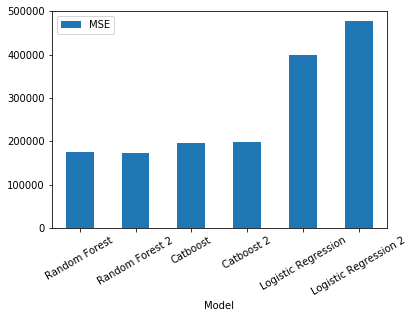

In [252]:
ax = df.plot.bar(x='Model', y='MSE', rot=30)

In [253]:
df

,Model,MSE
0,Random Forest,174846.044914
1,Random Forest 2,174026.361302
2,Catboost,195569.889920
3,Catboost 2,199485.668726
4,Logistic Regression,399655.317460
5,Logistic Regression 2,477780.920635


Niestety po dodaniu dodatkowych kolumn błąd prostego modelu zwiększył się znacznie - możliwe, że dodane punkty były zbyt mało szczegółowe i wybrałam zbiór danych który nie jest najlepszym przykładem, ponieważ większość jego zmiennych miała bardzo mało unikalnych wartości. 
Okazało się jednak, że dla modeli typu czarne skrzynki błąd pozostał właściwie na tym samym poziomie.